# How does cell size compares acrosss sources? --Using taxonomy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [4]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

Set bm1, bm4, bm5 as bergeys

In [5]:
df['sources'] = df['sources'].map(lambda x: 'bergeys' if x == 'bm1' or x == 'bm4' or x == 'bm5' else x)

In [6]:
df[df['sources'] == 'bacdive'][['length_ranges', 'width_ranges', 'species', 'length_gmean', 'width_gmean', 'length_amean', 'width_amean']]

,length_ranges,width_ranges,species,length_gmean,width_gmean,length_amean,width_amean
taxid,,,,,,,
taxid11,"1.5, 3.75","0.75, 1.5",Cellulomonas gilvus,2.371708,1.060660,2.625,1.125
taxid14,"5.0, 20.0","0.4, 0.6",Dictyoglomus thermophilum,10.000000,0.489898,12.500,0.500
taxid23,"1.5, 1.5","0.7, 0.7",Shewanella colwelliana,1.500000,0.700000,1.500,0.700
taxid104,"0.9, 1.2","0.3, 0.4",Cyclobacterium marinum,1.039230,0.346410,1.050,0.350
taxid198,"1.2, 2.5","0.2, 0.5",Campylobacter hyointestinalis,1.732051,0.316228,1.850,0.350
...,...,...,...,...,...,...,...
taxid2338647,"0.5, 2.0","0.5, 1.0",Ottowia konkukae,1.000000,0.707107,1.250,0.750
taxid2364026,"2.0, 4.0","0.6, 0.6",Bradyrhizobium ripae,2.828427,0.600000,3.000,0.600
taxid2494234,"1.7, 2.1","1.7, 2.1",Sutterella megalosphaeroides,1.889444,1.889444,1.900,1.900


Giant bacteria

In [62]:
df.query('length_gmean > 10 | width_gmean > 10')[['phylum']].value_counts()

phylum        
Spirochaetes      63
Bacteroidetes     25
Firmicutes        22
Cyanobacteria     12
Proteobacteria     8
Chloroflexi        6
Actinobacteria     4
Crenarchaeota      3
Euryarchaeota      3
Fusobacteria       2
Thermotogae        2
Balneolaeota       1
Dictyoglomi        1
Name: count, dtype: int64

In [120]:
df.query('phylum == "Crenarchaeota"').shape

(34, 30)

In [121]:
np.log10(0.4)

-0.3979400086720376

In [122]:
np.log10(1.2)

0.07918124604762482

In [7]:
columns = ['bacdive', 'pcc', 'bergeys', 'pubmed']
colors = {'bacdive': '#264653', 'pcc': '#2a9d8f', 'pubmed': '#ef476f', 'bergeys': '#f4a261'}

In [7]:
def adjacent_values(vals, q1, q3):
    print(len(vals))
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [8]:
df['vsratio'] = df['volume_gmean'] / df['surface_gmean']

In [9]:
metric = 'vsratio'

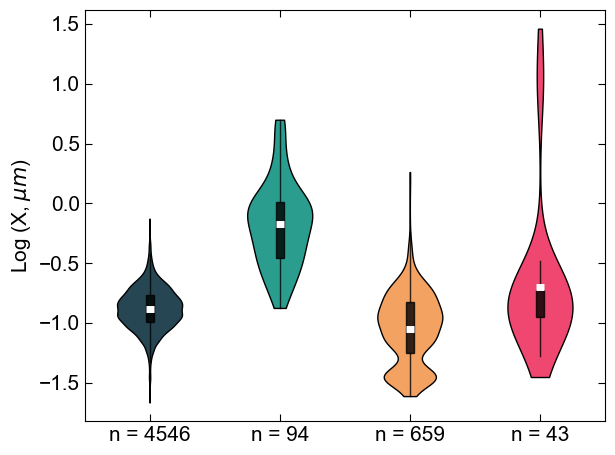

In [10]:
plt.figure()

data = [df[df['sources'] == c][metric].apply(np.log10) for c in columns]

parts = plt.violinplot(data, showmeans = False, showmedians = False, showextrema = False)
for pc, s in zip(parts['bodies'], columns):
    pc.set_facecolor(colors[s])
    pc.set_edgecolor('k')
    pc.set_alpha(1)
    
plt.boxplot(data, whis = None, showmeans = True, meanline = True,
            showcaps = False, widths = 0.06, patch_artist = True,
            boxprops = dict(color = 'k', facecolor = 'k', alpha = 0.8),
            whiskerprops = dict(color = 'k', linewidth = 1, alpha = 0.8),
            medianprops = dict(color = 'k', linewidth = 0.1, alpha = 0.1),
           meanprops = dict(color = 'w', linewidth = 5))



plt.ylabel(f'Log (X, $\\mu m$)')
plt.xticks([1, 2, 3, 4], [f'n = {len(data[0])}', f'n = {len(data[1])}', f'n = {len(data[2])}', f'n = {len(data[3])}'])

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

plt.show()

Get taxonomic groups with more than `num` species across taxonomic levels

In [17]:
num = 0
levels = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [18]:
tmp = {'rank': [], 'taxon': [], 'counts': [], 'bacdive': [], 'pcc': [], 'bergeys': [], 'pubmed': []}
for level in levels[1:-1]:
    counts = df[df[level].notna()][[level]].value_counts()
    for taxon in counts.index:
        n = counts.loc[taxon]
        if n > num:
            sources = df[df[level] == taxon[0]]['sources'].value_counts().to_dict()
            # Add to dictionary
            tmp['rank'].append(level)
            tmp['taxon'].append(taxon[0])
            tmp['counts'].append(n)
            for s in ['bacdive', 'pcc', 'bergeys', 'pubmed']:
                if s in sources.keys():
                    tmp[s].append(sources[s])
                else:
                    tmp[s].append(0)            
            
df_taxa = pd.DataFrame.from_dict(tmp)

In [19]:
df_taxa = pd.DataFrame.from_dict(tmp)
df_taxa.set_index('taxon', inplace = True)

In [20]:
df_taxa.head(n = 10)

,rank,counts,bacdive,pcc,bergeys,pubmed
taxon,,,,,,
Proteobacteria,phylum,2048,2023,0,0,25
Bacteroidetes,phylum,963,962,0,0,1
Firmicutes,phylum,801,788,0,0,13
Actinobacteria,phylum,755,476,0,252,0
Tenericutes,phylum,173,0,0,170,0
Euryarchaeota,phylum,135,63,0,71,0
Spirochaetes,phylum,114,23,0,83,2
Cyanobacteria,phylum,97,1,94,0,2
Verrucomicrobia,phylum,43,32,0,11,0


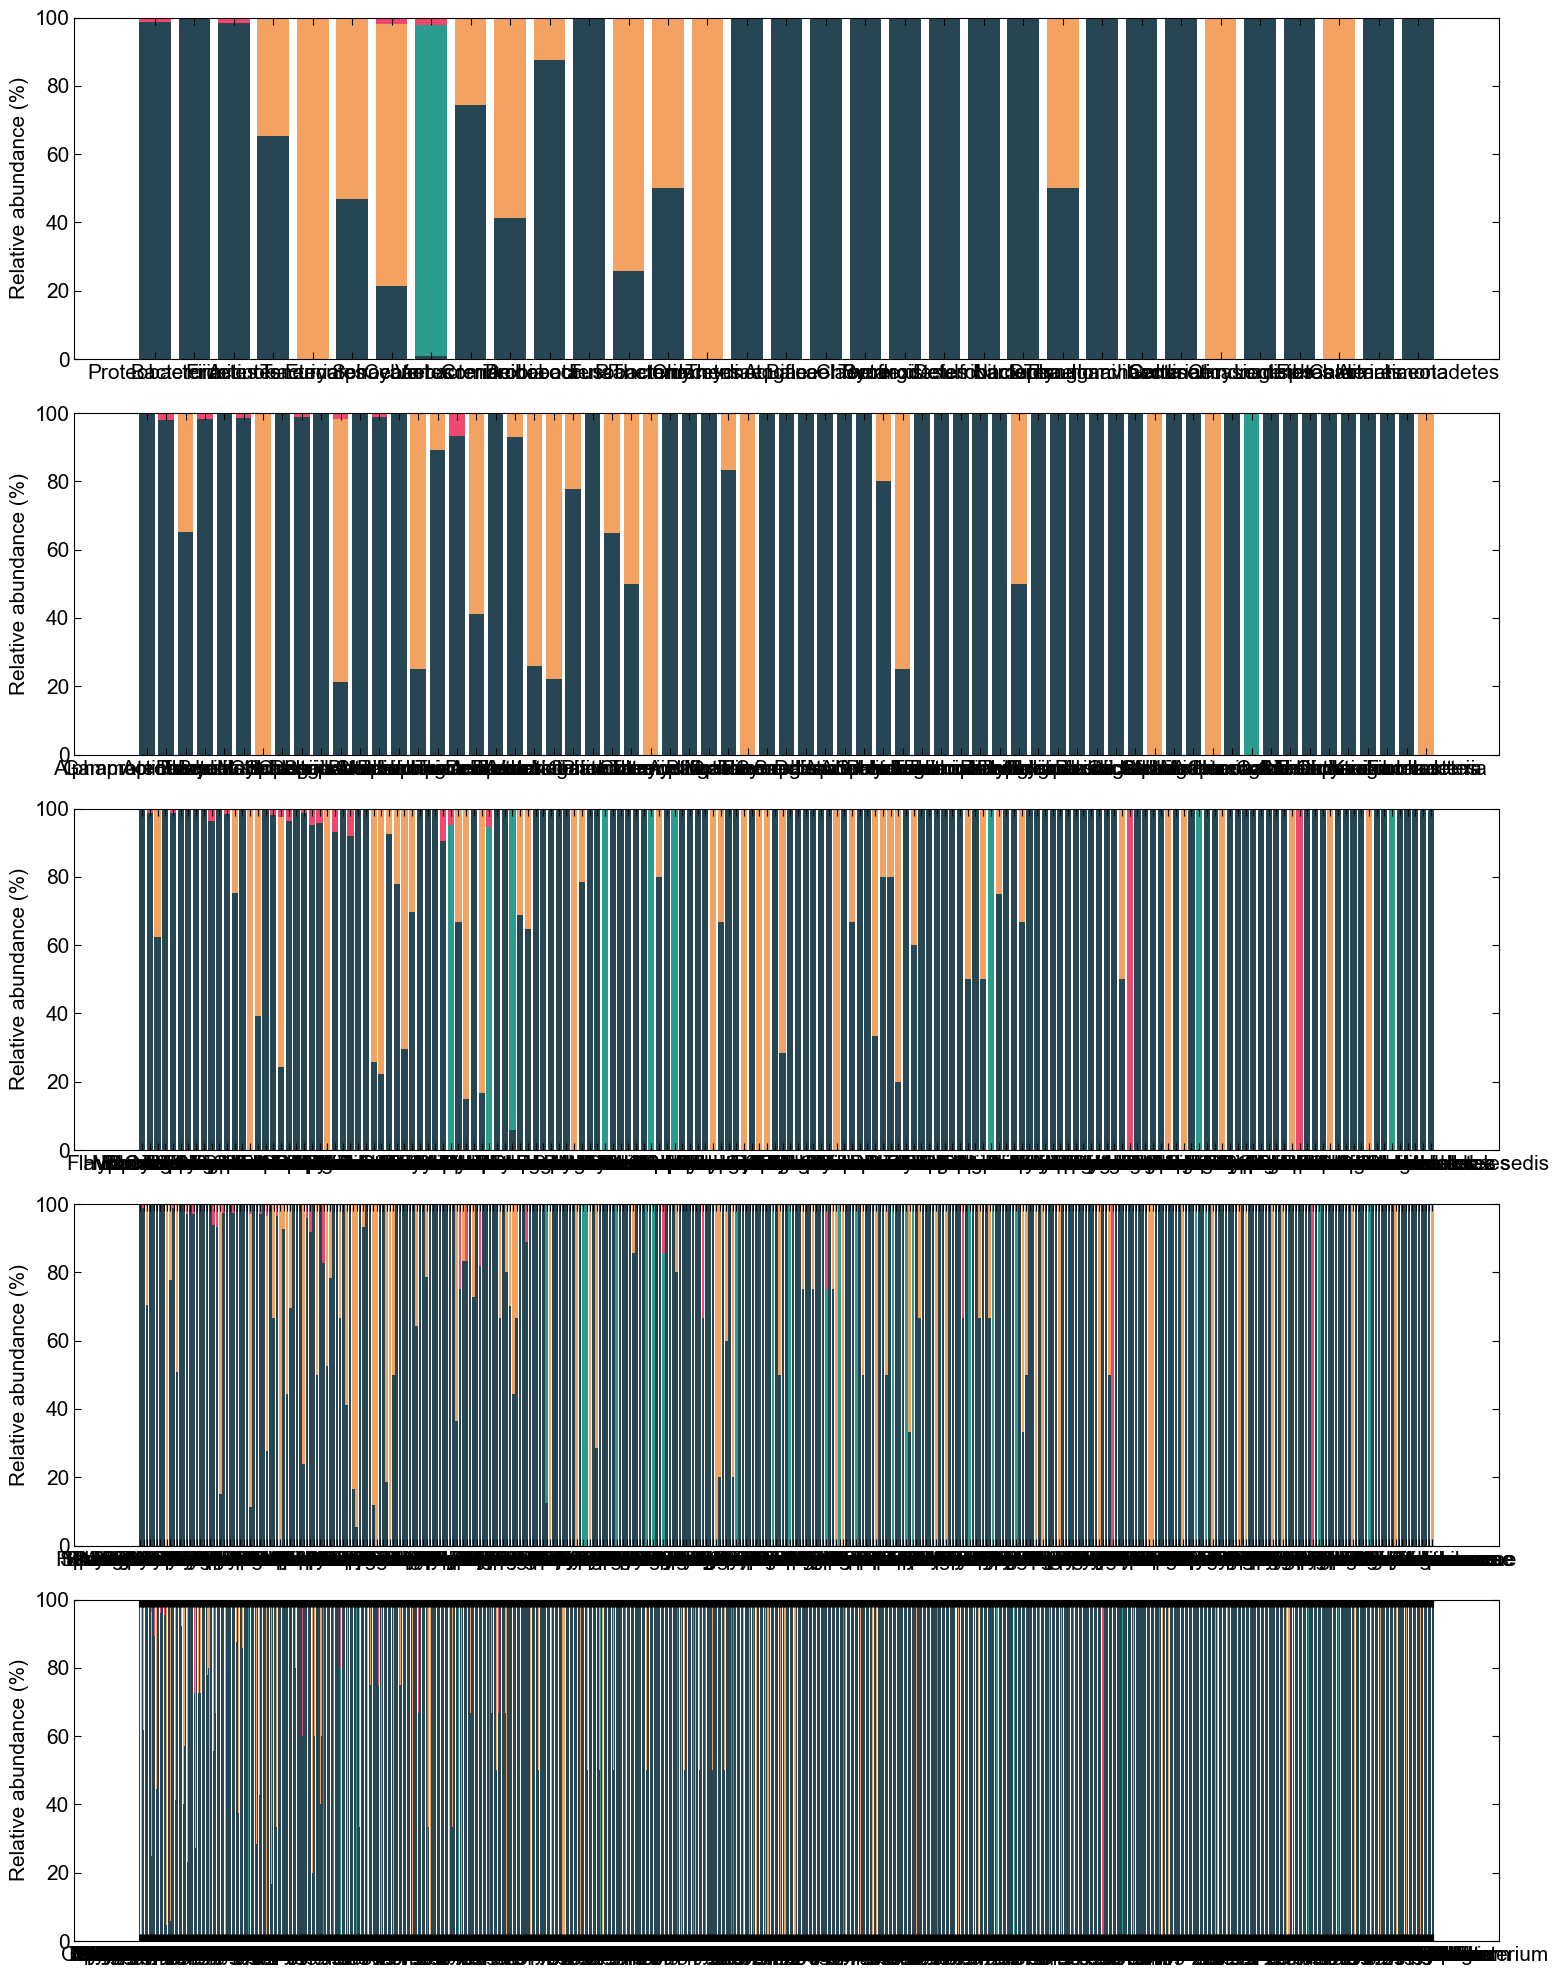

In [22]:
fig, ax = plt.subplots(5, 1, figsize = (16, 20), 
                       sharey = True, sharex = False)

for i, level in enumerate(levels[1:-1]):
    # Data
    data = df_taxa[df_taxa['rank'] == level][columns].T
    # Normalize counts
    data = data / data.sum(axis = 0) * 100
    # Sort by relative abundance
    data = data.loc[data.sum(axis = 1).sort_values(ascending = False).index]
    bottom = np.zeros(data.shape[1])
    # Barplot
    for s, datum in data.iterrows():
        ax[i].bar(data.columns, datum.values, bottom = bottom, color = colors[s])
        bottom += datum 
    
    # ax[i].set_xticklabels(data.columns, rotation = 20)
    # Labels and ticks
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    ax[i].tick_params(which = 'major', length = 5)
    ax[i].tick_params(which = 'minor', length = 3)
    ax[i].set_ylabel('Relative abundance (%)')
    
plt.show()

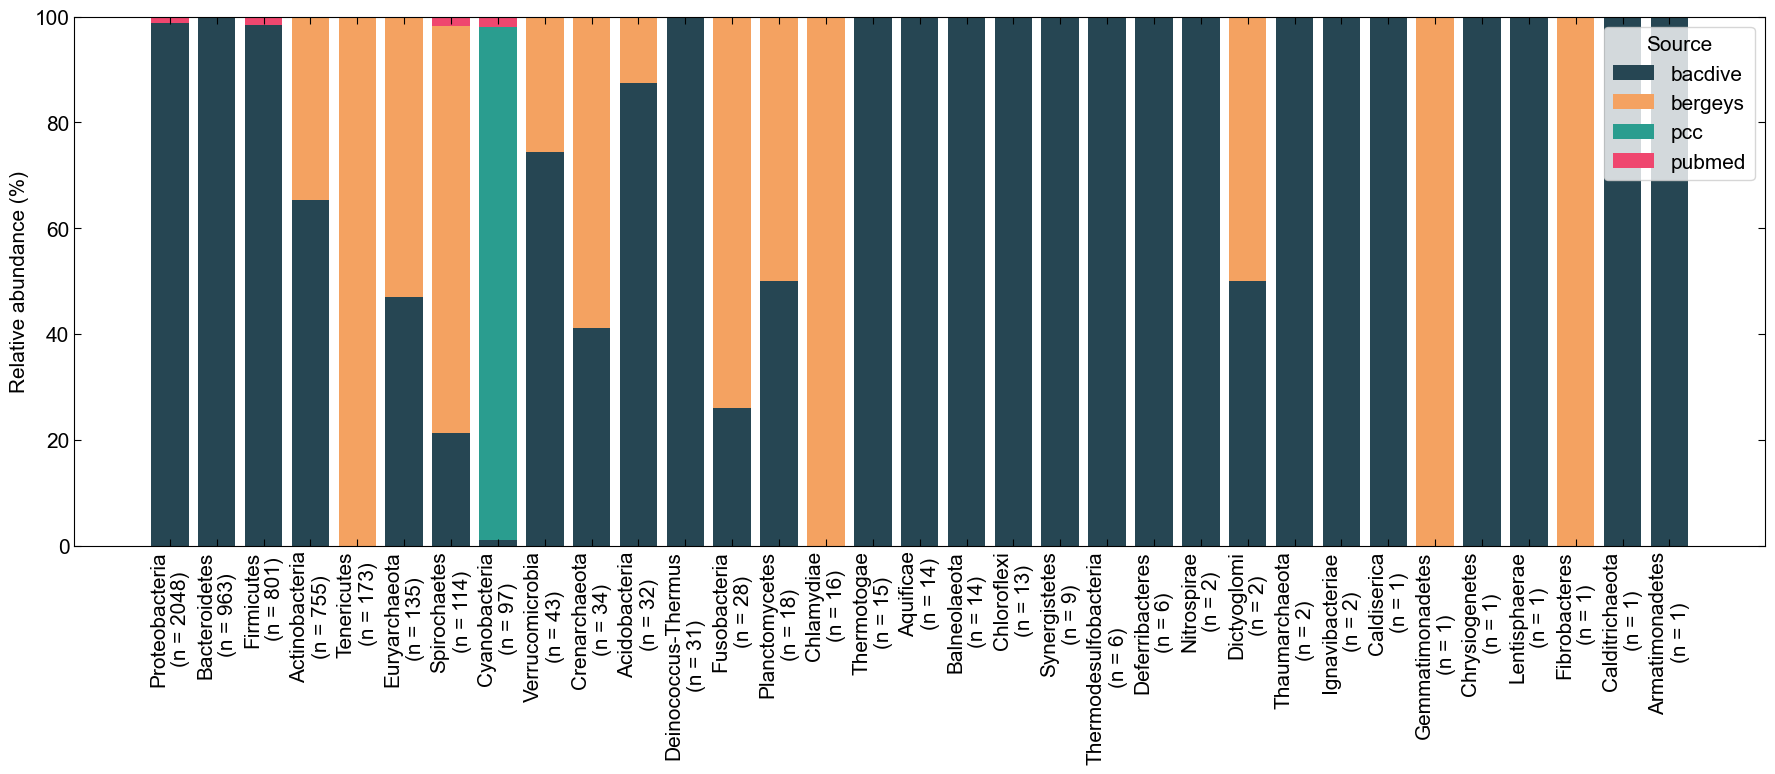

In [26]:
fig = plt.figure(figsize = (18, 8))

for i, level in enumerate(levels[1:2]):
    # Data
    data = df_taxa[df_taxa['rank'] == level][columns].T
    # Normalize counts
    data = data / data.sum(axis = 0) * 100
    # Sort by relative abundance
    data = data.loc[data.sum(axis = 1).sort_values(ascending = False).index]
    bottom = np.zeros(data.shape[1])
    # Barplot
    for s, datum in data.iterrows():
        plt.bar(data.columns, datum.values, bottom = bottom, color = colors[s], label = s)
        bottom += datum 
    
    # plt.xticks(np.arange(len(data.columns)), data.columns, rotation = 45)
    plt.xticks(np.arange(len(data.columns)),
               [f'{c}\n(n = {df_taxa[df_taxa["rank"] == level].loc[c]["counts"]})' for c in data.columns],
               rotation = 90)
    # Labels and ticks
    plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
    plt.tick_params(which = 'major', length = 5)
    plt.tick_params(which = 'minor', length = 3)
    plt.ylabel('Relative abundance (%)')
    plt.legend(title = 'Source')

plt.savefig('figures/phylum_sources.svg')
plt.show()

**Only a few taxonomic groups have an equal number of species collected from more than one source.**

Let's analyze their distribution to assess whether a batch effect exist across sources, mainly BacDive and Bergey's manual.

Filter taxons with less than `n` species per source for statistical consistency

In [38]:
n = 20

In [39]:
df_taxa_filter = df_taxa[(df_taxa['bacdive'] > n) & (df_taxa['bergeys'] > n)].copy()

In [40]:
df_taxa_filter

,rank,counts,bacdive,pcc,bergeys,pubmed
taxon,,,,,,
Actinobacteria,phylum,755,476,0,252,0
Euryarchaeota,phylum,135,63,0,71,0
Spirochaetes,phylum,114,23,0,83,2
Actinomycetia,class,727,456,0,244,0
Spirochaetia,class,114,23,0,83,2
Micrococcales,order,349,211,0,127,0
Propionibacteriales,order,128,95,0,31,0
Corynebacteriales,order,112,40,0,62,0
Microbacteriaceae,family,159,109,0,46,0


In [41]:
def ttest(data):
	'''
	Function that checks the assumptions of t-test
	Inputs:
		data: list containing two numpy arrays
	'''
	# Homocedasticity or heterocedasticity
	equal_var = True
	var1, var2 = np.var(data[0]), np.var(data[1])
	stat_levene, pval_levene = stats.levene(data[0], data[1])
	if pval_levene < 0.05:
		equal_var = False

	# Normality
	stat_shapiro1, pval_shapiro1 = stats.shapiro(data[0])
	stat_shapiro2, pval_shapiro2 = stats.shapiro(data[1])

	# If sample size is large, variances do not differ greatly, then deviation from normality is tolerated
	stat_ttest, pval_ttest = stats.ttest_ind(data[0], data[1], equal_var = equal_var)

	return stat_ttest, pval_ttest

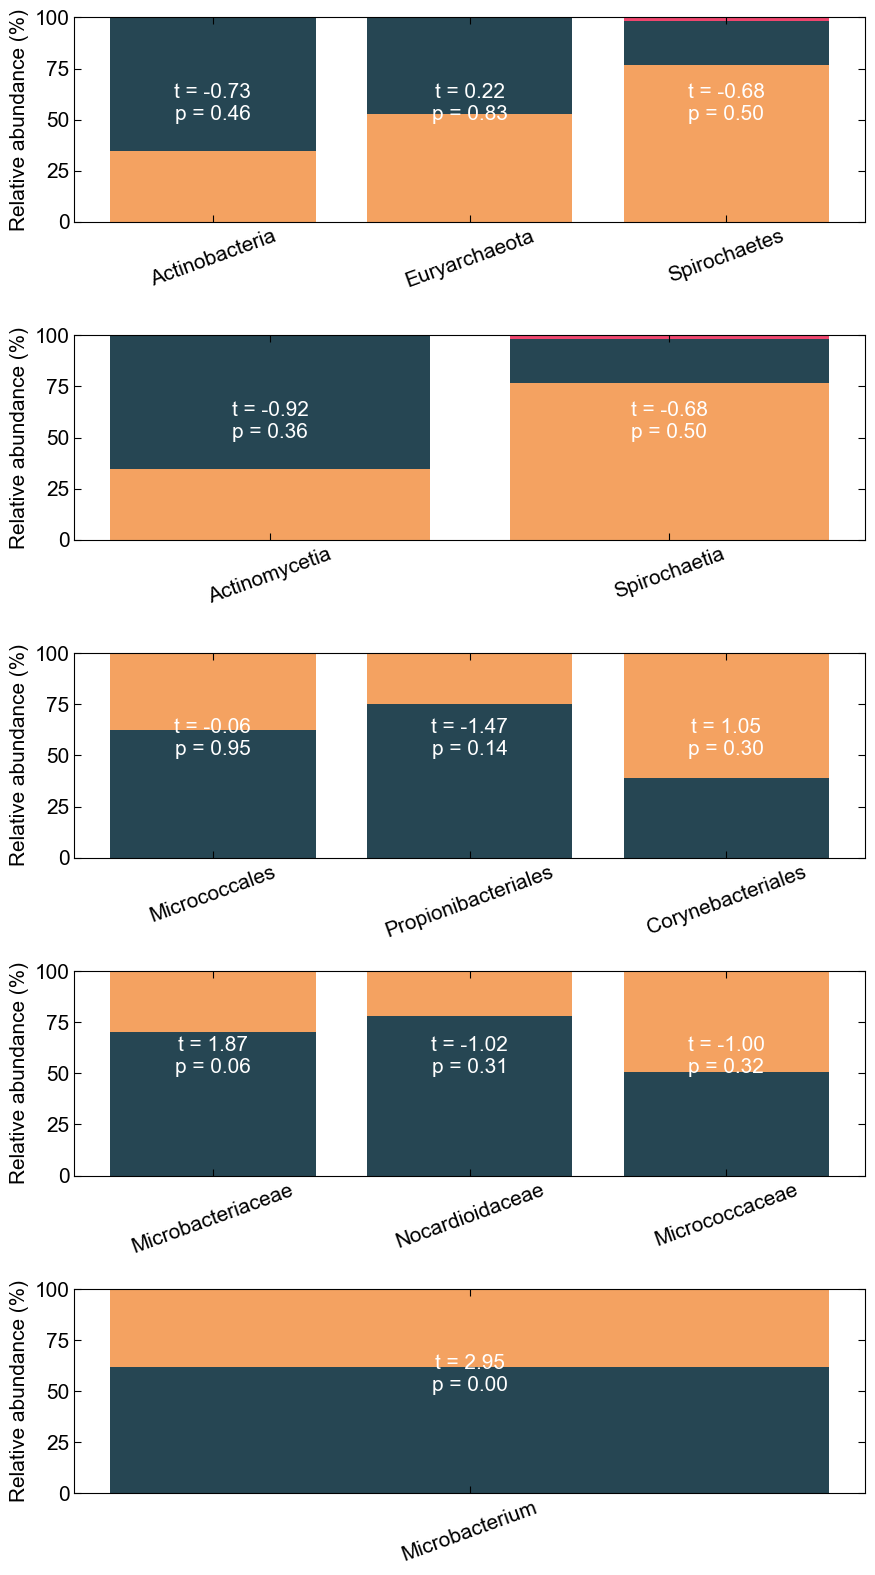

In [42]:
fig, ax = plt.subplots(5, 1, figsize = (9, 16), 
                       sharey = True, sharex = False)

for i, level in enumerate(levels[1:-1]):
    # Let's only focus at the phylum level
    # if level == 'phylum':
    # Data
    data = df_taxa_filter[df_taxa_filter['rank'] == level][columns].T
    
    # Normalize counts
    data = data / data.sum(axis = 0) * 100
    # Sort by relative abundance
    data = data.loc[data.sum(axis = 1).sort_values(ascending = False).index]
    bottom = np.zeros(data.shape[1])
    # Barplot
    for s, datum in data.iterrows():
        ax[i].bar(data.columns, datum.values, bottom = bottom, color = colors[s])
        bottom += datum 

    # t-test
    for j, tx in enumerate(data.columns):
        datum = [df[(df[level] == tx) & (df['sources'] == 'bacdive')][metric].apply(np.log10).to_numpy(),
                    df[(df[level] == tx) & (df['sources'] == 'bergeys')][metric].apply(np.log10).to_numpy()]
        stat, pval = ttest(datum)
        # stat, pval = stats.mannwhitneyu(datum[0], datum[1])
        
        ax[i].text(j, 50, f't = {stat:.2f}\np = {pval:.2f}', ha = 'center',
                  color = 'white')
            
    ax[i].set_xticks(np.arange(len(data.columns)))
    ax[i].set_xticklabels(data.columns, rotation = 20)
    # Labels and ticks
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    ax[i].tick_params(which = 'major', length = 5)
    ax[i].tick_params(which = 'minor', length = 3)
    ax[i].set_ylabel('Relative abundance (%)')

plt.savefig('figures/phylum_sources_stats.svg')
plt.show()